# Visualizing Grover's Search Algorithm

This is a companion notebook to the [Exploring Grover's Search Algorithm](./ExploringGroversAlgorithmTutorial.ipynb) tutorial. It helps you explore the algorithm by plotting several graphs that are a lot easier to build using Python than in a purely Q# notebook.

> <font color="red">This notebook contains some heavy computations, and might take a fair amount of time to execute. 
    Precomputed cell outputs are included - you might want to study these before you opt to re-run the cells.</font>

## Running Q# code from Python

To start with, execute this cell using Ctrl+Enter (or ⌘+Enter on a Mac). This is necessary to prepare the environment and import the libraries and operations we'll use later in the tutorial.

In [1]:
import qsharp
import Quantum.Kata.ExploringGroversAlgorithm as Grover

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
from matplotlib import pyplot

Preparing Q# environment...
...

`GroversAlgorithm_SuccessProbability` is a pre-written Q# operation similar to the one you've implemented in the [exercise 5](./ExploringGroversAlgorithmTutorial.ipynb#Exercise-5:-Calculate-the-success-probability-of-Grover's-algorithm): 
given the instance of a SAT problem and the number of iterations, it runs Grover's search on that instance for that number of iterations and calculates the probability of its success.

You can call this operation from Python as follows (note that the only change in the syntax used for describing instances of SAT problems is that in Q# the constants `true` and `false` are spelled in lowercase, and in Python the first letter is capitalized):

In [2]:
# The SAT instance we want to solve
problem = [[(0, True), (1, True)], [(0, False), (1, False)], [(1, True), (2, True)], [(1, False), (2, False)]]
variableCount = 3

print("Solving SAT problem " + Grover.SATInstanceAsString.simulate(instance = problem) + "...")

# Simulate the algorithm and print the results
successProb = Grover.SuccessProbability_SAT.simulate(N = variableCount, instance = problem, iter = 1)
print("The algorithm succeeds with " + str(successProb * 100) + "% probability")

Solving SAT problem (x0 ∨ x1) ∧ (¬x0 ∨ ¬x1) ∧ (x1 ∨ x2) ∧ (¬x1 ∨ ¬x2)...
The algorithm succeeds with 100.0% probability


Now that we have the tools for running Grover's search algorithm from Python and calculating its success probability, 
let's use them to collect and plot some information about the behavior of the algorithm's success probability.

## Exploring success probability

Let's start by considering a larger problem instance with exactly 1 solution and exploring how the success probability of the algorithm depends on the number of Grover iterations done.

> For the sake of speeding up the plotting we will use hardcoded oracles which implement functions with a given number of solutions instead of a proper SAT-solving oracles. The behaviors we will be exploring do not depend on the exact problem solved by the oracle!

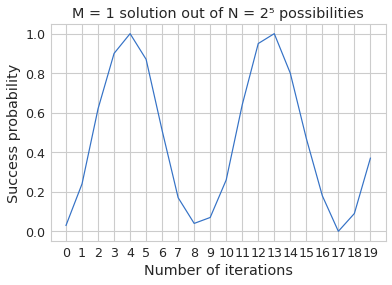

In [3]:
x_points = range(20)
y_points = [-1.0] * 20

for iter in x_points:
    y_points[iter] = Grover.SuccessProbability_Sol.simulate(nQubit = 5, nSol = 1, iter = iter)
    
# Plot the data
fig = pyplot.figure()
ax = fig.add_subplot(111)
p = ax.plot(x_points, уy_points, 'b')
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Success probability')
ax.set_title('M = 1 solution out of N = 2⁵ possibilities')
ax.set_xticks(range(20))
fig.show()

We can observe a very important property of the algorithm on this plot: **more iterations does not mean better!**  
The success probability increases until it hits a maximum of 1.0 at 4 iterations, after that it decreases again until a minimum of 0.0 at 8 iterations, and after that the pattern repeats. 

## How to maximize success probability?

Let's take a look at more data: how does success probability change as the number of iterations increases depending on the number of solutions the problem has.

> Note that the execution of this cell can take several minutes.

In [4]:
x_points = range(20)
y_points = []

for sol in range(4):
    yp = [-1.0] * 20
    for iter in x_points:
        yp[iter] = Grover.SuccessProbability_Sol.simulate(nQubit = 5, nSol = sol + 2, iter = iter)
    y_points.append(yp)

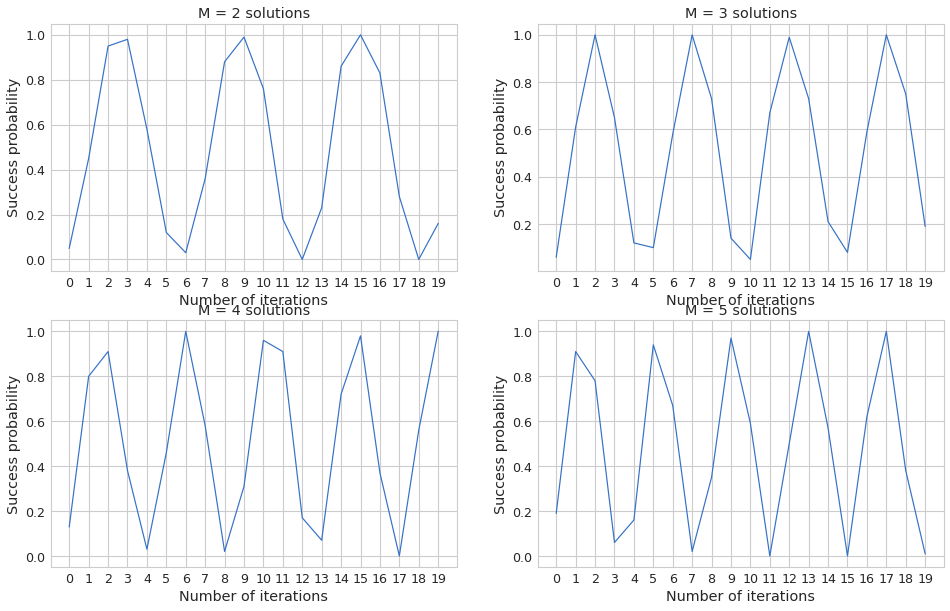

In [5]:
# Plot the data
fig, axes = pyplot.subplots(2, 2, figsize=(16, 10))
for sol in range(4):
    ax = axes.flatten()[sol]
    ax.plot(x_points, y_points[sol])
    ax.set_xlabel('Number of iterations')
    ax.set_ylabel('Success probability')
    ax.set_title('M = ' + str(sol+2) + ' solutions')
    ax.set_xticks(range(20))
fig.show()

You can see that the pattern remains the same on each plot: the success probability increases to nearly 1.0 at a certain number of iterations, after that it decreases to nearly 0.0 at approximately double that number of iterations, and after that the pattern repeats. 

However, the number of iterations at which the maximum success probability is achieved is different for different problems: for problems with 1 solution it was 4 iterations, for 2 solutions - 3 iterations, for 3 and 4 solutions - 2 iterations, and for 5 solutions - 1 iteration. The formula for the optimal number of iterations is 

$$R \approx \frac{\pi}{4} \sqrt{\frac{N}{M}}$$

where $N$ is the size of the search space (in our case we have 5 binary variables, so $N = 2^5 = 32$), $M$ is the number of solutions to the problem (in our case between 1 and 5).

This formula shows the reason Grover's search is so interesting - the classical solution to the search problem requires $O(N)$ evaluations of the function, and Grover's search algorithm allows to do this in $O(\sqrt{N})$ evaluations, providing a quadratic speedup.

## Calculating the optimal number of iterations

Where does the formula $R \approx \frac{\pi}{4}\sqrt{\frac{N}{M}} $ come from?
We can derive the optimal number of iterations from first principles, and see which assumptions went into this formula and in what cases it is not accurate.

Grover's search begins with a uniform superposition of all $N=2^n$ states in the search space:
$$|all\rangle = \frac{1}{\sqrt{N}}\sum_{x=0}^{N-1}{|x\rangle} $$

When we're looking at the equation $f(x) = 1$, we can rewrite this expression in terms of basis states that are "good" (solutions) and "bad" (non-solutions):
$$ |all\rangle = \sqrt{\frac{M}{N}}|good\rangle + \sqrt{\frac{N-M}{N}}|bad\rangle$$
Here $M$ is the number of states for which $f(x)=1$ (the number of equation solutions), and
$$
|good\rangle = \frac{1}{\sqrt{M}}\sum_{x,f(x)=1}{|x\rangle}\\
|bad\rangle = \frac{1}{\sqrt{N-M}}\sum_{x,f(x)=0}{|x\rangle}
$$

The effect of the phase oracle used in Grover's algorithm on these states will be the flipping the phase of all basis states in $|good\rangle$ and leaving $|bad\rangle$ unchanged:
$$O|good\rangle =-|good\rangle \\ O|bad\rangle =|bad\rangle$$

Let's rewrite the coefficients in the $|all\rangle$ representation to trigonometric ones as follows:
$$ |all\rangle = \sin{\theta}|good\rangle + \cos{\theta}|bad\rangle \\ 
\sin \theta = \sqrt{\frac{M}{N}}, \cos \theta = \sqrt{\frac{N-M}{N}}$$

Grover's operator can be represented as $G = UO$, where $O$ is the phase oracle which implements the function $f(x)$, and $U = H^{\otimes n}(2|0\rangle\langle0|-I)H^{\otimes n}$ is the "reflection about the mean". 

Each iteration of Grover's search adds $2\theta$ to the current angle in the expression of the system state as a superposition of $|good\rangle$ and $|bad\rangle$.
After applying $R$ iterations of Grover's search the state of the system will be

$$ G^R|all\rangle = \sin{(2R+1)\theta}|good\rangle + \cos{(2R+1)\theta}|bad\rangle$$

<details>
    <summary><b>Click here for the complete proof of the above statement</b></summary>

*Note: The math below is terse but not that complicated. 
However, it requires some prior knowledge of trigonometry identities as well as ket-bra algebra.*

Let's prove the result 
$G^R|\psi\rangle = \sin{(2R+1)\theta}|good\rangle + \cos{(2R+1)\theta}|bad\rangle$ by induction.

#### Base case

When $R=0$, $G^R=G^0=I$ and $2R+1=2\times0+1=1$.

Thus $G^0|\psi\rangle = \sin{(2\times 0+1)\theta}|good\rangle + \cos{(2\times 0+1)\theta}|bad\rangle 
= \sin{\theta}|good\rangle + \cos{\theta}|bad\rangle = |\psi\rangle$
is true.

#### Inductive step 

Let us assume this is true for all $R \leq k$, i.e.,
$G^{k}|\psi\rangle = \sin{(2k+1)\theta}|good\rangle + \cos{(2k+1)\theta}|bad\rangle$.

#### Induction proof

Let us show that $G^{k+1}|\psi\rangle = \sin{(2(k+1)+1)\theta}|good\rangle + \cos{(2(k+1)+1)\theta}|bad\rangle$. 

We know that since all states in $|good\rangle$ are marked and all states in $|bad\rangle$ are unmarked, therefore,
$O|good\rangle =-|good\rangle$ and $O|bad\rangle =|bad\rangle$. 

Thus by linearity of the quantum oracle $O$, 
$$O(\sin{(2k+1)\theta}|good\rangle + \cos{(2k+1)\theta}|bad\rangle) = 
-\sin{(2k+1)\theta}|good\rangle + \cos{(2k+1)\theta}|bad\rangle$$

Note that the states $|good\rangle$ and $|bad\rangle$ are orthogonal (since they don't share any basis states), i.e., $\langle bad|good\rangle =\langle good|bad\rangle=0$.

Now let's consider reflection about the mean:
$$U =  H^{\otimes n}(2|0\rangle\langle0|-I)H^{\otimes n} 
= 2H^{\otimes n}|0\rangle\langle0|H^{\otimes n} - I $$

We know that $H^{\otimes n}|0\rangle = \frac{1}{N}\sum_{x=0}^{N-1}|x\rangle = |\psi\rangle = \sin\theta|good\rangle + \cos\theta|bad\rangle$.

Thus, 
$$ U = 2|\psi\rangle\langle \psi| - I = \\
= 2\big(\sin{\theta}|good\rangle + \cos{\theta}|bad\rangle\big)\big(\sin{\theta}\langle good| + \cos{\theta}\langle bad|\big) - I = \\
= 2\big(\sin^2{\theta}|good\rangle\langle good|+ \cos{\theta}\sin{\theta}|bad\rangle\langle good| 
+ \cos{\theta}\sin{\theta}|good\rangle\langle bad| + \cos^2{\theta}|bad\rangle\langle bad|\big) - I$$

Now we can write $G^{k+1}|\psi\rangle$ as follows:
$$G^{k+1}|\psi\rangle = G\big(G^k|\psi\rangle\big) = \\ 
= G\big(\sin{(2k+1)\theta}|good\rangle + \cos{(2k+1)\theta}|bad\rangle\big) = \\
= UO\big(\sin{(2k+1)\theta}|good\rangle + \cos{(2k+1)\theta}|bad\rangle\big) = \\
= U\big(-\sin{(2k+1)\theta}|good\rangle + \cos{(2k+1)\theta}|bad\rangle\big) = \\
= \big(2(\sin^2{\theta}|good\rangle\langle good| + \cos{\theta}\sin{\theta}|bad\rangle\langle good| 
+ \cos{\theta}\sin{\theta}|good\rangle\langle bad| + \cos^2{\theta}|bad\rangle\langle bad|) - I\big) \cdot \\
\cdot \big(-\sin{(2k+1)\theta}|good\rangle + \cos{(2k+1)\theta}|bad\rangle\big)
$$

If we expand this expression, cancel out the terms where inner product is zero, and combine the coefficients at the same state, we'll get

$$ G^{k+1}|\psi\rangle = U\big(-\sin{(2k+1)\theta}|good\rangle + \cos{(2k+1)\theta}|bad\rangle\big) = \\
= \big((1-2\sin^2{\theta})\sin{(2k+1)\theta} 
+ (2\cos{\theta}\sin{\theta})\cos{(2k+1)\theta}\big)|good\rangle + \\
+ \big(-(2\cos{\theta}\sin{\theta})\sin{(2k+1)\theta}
+ (2\cos^2{\theta}-1)\cos{(2k+1)\theta}\big)|bad\rangle$$ 

Using some trigonometry we can simply it further:
$$ G^{k+1}|\psi\rangle = \big(\cos2\theta\sin{(2k+1)\theta} + \sin2\theta\cos{(2k+1)\theta}\big)|good\rangle
+ \big(-\sin2\theta\sin{(2k+1)\theta} + \cos2\theta\cos{(2k+1)\theta}\big)|bad\rangle = \\
= \sin(2\theta + {(2k+1)\theta})|good\rangle + \cos(2\theta + {(2k+1)\theta})|bad\rangle = \\
= \sin{(2k+3)\theta}|good\rangle + \cos{(2k+3)\theta}|bad\rangle = \\
= \sin{(2(k+1)+1)\theta}|good\rangle + \cos{(2(k+1)+1)\theta}|bad\rangle $$

This is exactly what we wanted to show, thus our proof by induction is complete.
</details>

In order to maximize the probability of finding a solution when we measure, we want the amplitude of the $|good\rangle$ state to be as close to 1 as possible. 
After $R$ iterations this amplitude equals $\sin{(2R+1)\theta}$, so we're looking for $R$ that is a solution to
$$\sin (2R+1)\theta \approx 1 \\ 
(2R+1)\theta \approx \frac{\pi}{2} \\
2R+1 \approx \frac{\pi}{2\theta}$$

We can arrive to the same conclusion using a neat visualization of the Grover's search iterations.

<table style="border:0px solid">
    <col width=5%>
    <col width=45%>
    <col width=40%>
    <col width=10%>
    <tr><td/>
        <td style="text-align:left"><font size=+0.5>Imagine a plane on which $|good\rangle$ and $|bad\rangle$ vectors correspond to vertical and horizontal axes, respectively. We can represent the starting state $|all\rangle$ as a superposition of these states:</font></td>
        <td style="text-align:center"><img src="./img/5-1-equal-superposition.png"/></td>
    <td/></tr>
    <tr><td/>
        <td style="text-align:left"><font size=+0.5>Each Grover's iteration consists of two steps. The first step is applying the phase oracle, which multiplies the amplitudes of "good" states by $-1$. On the circle plot, this transformation leaves the horizontal component of the state vector unchanged and reverses its vertical component. In other words, this operation is a reflection along the horizontal axis:</font></td>
        <td style="text-align:center"><img src="./img/5-2-first-reflection.png"/></td>
    <td/></tr>
    <tr><td/>
        <td style="text-align:left"><font size=+0.5>The second step is applying the diffusion operator. Its effect is another reflection, this time along the vector $|all\rangle$:</font></td>
        <td style="text-align:center"><img src="./img/5-3-second-reflection.png"/></td>
    <td/></tr>
</table>

The Grover's iteration is a sequence of these two reflections, which, combined, produce a counterclockwise rotation by an angle $2\theta$. If we repeat the iteration, reflecting the new state first along the horizontal axis and then along the $|all\rangle$ vector, it performs a rotation by $2\theta$ again. The angle of this rotation depends only on the angle between the reflection axes and not on the state we reflect!

<table style="border:0px solid">
    <col width=5%>
    <col width=45%>
    <col width=40%>
    <col width=10%>
    <tr><td/>
        <td style="text-align:left"><font size=+0.5>When should we perform the measurement?<br/><br/>
            The probability of getting a certain basis state as the measurement outcome equals the squared amplitude of that state in the superposition. The greater the amplitude, the higher the chance of getting the corresponding state when performing the measurement.
<br/><br/>
Since our goal is to get one of the "good" states with probability as high as possible, we need to increase the amplitudes of "good" states as much as we can (and reduce the amplitudes of "bad" states correspondingly). Geometrically, this means that we want to rotate our state vector as close to the vertical axis as possible.</font></td>
        <td style="text-align:center"><img src="./img/5-4-measurement.png"/></td>
    <td/></tr>
    <tr><td/>
        <td style="text-align:left"><font size=+0.5>Our initial state started with the angle $\theta$ to the horizontal axis, and every iteration rotates it $2\theta$ counterclockwise, so the angle after $R$ rotations is $(2R+1)\theta$, and we want it to be as close to $\frac{\pi}{2}$ as possible to be close to the vertical axis: <br/> 
<center>$(2R+1)\theta \approx \frac{\pi}{2}$</center>
<br/><br/>
This also explains the decrease in success probability if we keep iterating. More iterations will over-rotate our state, which will start getting further and further away from the vertical axis, thus reducing our success probability.</font></td>
        <td style="text-align:center"><img src="./img/5-5-overrotation.png"/></td>
    <td/></tr>
</table>

Now let's recall that $\theta = \arcsin \sqrt{\frac{M}{N}}$. When $M$ is much smaller than $N$, $\frac{M}{N}$ is close to 0, $\theta$ is a small angle, and we can approximate $\theta \approx \sqrt{\frac{M}{N}}$:

$$ 2R+1 \approx \frac{\pi}{2\theta} = \frac{\pi}{2}\sqrt{\frac{N}{M}}$$
Since $\theta$ is small, $R$ is large, and we can ignore the $+1$ term, obtaining finally our formula:
$$ R \approx \frac{\pi}{4}\sqrt{\frac{N}{M}}$$

### The optimal number of iterations when the assumption that $M$ is much smaller than $N$ is invalid

Now, let's look at three scenarios where our assumptions are not valid.

### 1. What happens if there are no solutions?

We assumed that the equation $f(x) = 1$ has solutions, i.e., $M \neq 0$. What happens if $M = 0$, i.e., our problem doesn't have solutions?

In this case the starting system state  $|\psi\rangle = |bad\rangle$,  and $\theta = \arcsin \sqrt{\frac{M}{N}} = 0$.
No matter how many iterations we do, the probability of our measurement yielding a marked state is $0$.
In practice this means that Grover's search will yield a random non-solution every time. 
To detect that this is the case, we need to run the algorithm multiple times and note the distrubution of the results; if none of them are problem solutions, we can conclude that the problem doesn't have a solution.

### 2. What happens if the solutions make up exactly half of the search space?

If $M=\frac{N}{2}$, then $\theta = \arcsin \sqrt\frac{N/2}{N}  = \arcsin \sqrt\frac{1}{2} = \frac{\pi}{4}$.   
This means that after $R$ iterations $\sin{(2R+1)\theta} = \sin\frac{(2R+1)\pi}{4} = \pm \frac{1}{\sqrt{2}} $.  
The probability of the measurement yielding a solution is $P(|good\rangle) = \sin^2\frac{(2R+1)\theta}{2} = (\pm \frac{1}{\sqrt{2}})^2 = \frac{1}{2}$ regardless of the number of iterations.

### 3. What happens if the solutions make up more than half of the search space?
If $\frac{N}{2} < M \leq N$, then $\frac{\pi}{4} < \theta \leq \frac{\pi}{2}$. 
Now using even one iteration doesn't always increase $P(|good\rangle) = \sin^2{(2R+1)\theta}$, in fact the first iteration is likely to decrease the probability.

> Have you ever wondered why all tutorials on Grover's search start with two-bit functions? 
> That's the reason why - if you have only 1 bit, you only have $M=0$, $M=\frac{N}{2}$, or $M=N$, and none of these make for a good illustration of the algorithm!

If we want to handle scenarios 2 and 3 using Grover's search, we can increase the size of the search space $N$ (without changing $M$). 
We can do this by increasing the number of qubits $n$ to $n' = n+j$, so that the new size of the search space $N' = 2^{n'}$ is much bigger than $M$. 
In this case we also need to modify the oracle, so that it can act on $n'$ qubits instead of $n$. 
One way to do this is to define the new oracle $O'$ as follows: it applies $O$ to the first $n$ qubits if remaining $j$ qubits are in state $|0 ... 0\rangle$. 
Thus $O'$ is effectively a zero-controlled variant of $O$:
$$O' = O \otimes(|0\rangle\langle0|) + I^{\otimes n} \otimes (\sum_{k=1}^{2^j-1}|k\rangle\langle k|)$$

However, it is a lot easier to handle these scenarios classically. 
Indeed, selecting a random state has a probability of being a problem solution $p = \frac{M}{N} > \frac{1}{2}$! 
If we repeat this process $k$ times, the probability of success grows to $1- p^k$, thus by increasing $k$ we can get this probabilty as close to $1$ as we need.
For example, For $p=0.5$ and $k=10$ the probality of success is $\approx 99.9\%$.

### But I don't know how many solutions my problem has!

Indeed, in practical applications you don't usually know how many solutions your problem has before you start solving it. 
In this case you can pick the number of iterations as a random number between 1 and $\frac{\pi}{4} \sqrt{N}$, and if the search did not yield the result on the first run, re-run it with a different number of iterations.

# What's Next?

We hope you've enjoyed this tutorial and learned a lot from it! If you're looking to learn more about quantum computing and Q#, here are some suggestions:

* The [Quantum Katas](https://github.com/microsoft/QuantumKatas/) are sets of programming exercises on quantum computing that can be solved using Q#. They cover a variety of topics, from the basics like the concepts of superposition and measurements to more interesting algorithms like Grover's search.
* In particular, [GroverSearch kata](https://github.com/microsoft/QuantumKatas/tree/main/GroversAlgorithm) offers you exercises on implementing simple quantum oracles and a step-by-step implementation of Grover search algorithm (all the internals that were hidden under the hood of `GroversAlgorithm_Loop` operation in this tutorial!).
* [SolveSATWithGrover kata](https://github.com/microsoft/QuantumKatas/tree/main/SolveSATWithGrover) teaches you how to implement quantum oracles for SAT problems, starting with the simple building blocks like implementing AND and OR operations in a quantum way.
* [GraphColoring kata](https://github.com/microsoft/QuantumKatas/tree/main/GraphColoring) is another interesting kata that teaches you how to implement quantum oracles for graph coloring problems.
* [BoundedKnapsack kata](https://github.com/microsoft/QuantumKatas/tree/main/BoundedKnapsack) handles more complicated problem, the knapsack problem, showing how to use Grover's search for optimization problems.